# Loading modules

In [59]:
# Loading modules
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
%matplotlib inline

In [61]:
# change to your local paths
TRAIN_CSV_PATH = '../Data/FSDKaggle2018.meta/train_post_competition.csv'
TEST_CSV_PATH = '../Data/FSDKaggle2018.meta/test_post_competition_scoring_clips.csv'
TRAIN_DATA_PATH = '../Data/FSDKaggle2018.audio_train/'
TEST_DATA_PATH = '../Data/FSDKaggle2018.audio_test/'

# Loading csv data

In [62]:
# loading data
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)
train_df

,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,0033e230.wav,Glockenspiel,1,325017,Attribution
4,00353774.wav,Cello,1,195688,Attribution
...,...,...,...,...,...
9468,ffec59fb.wav,Fireworks,0,343090,Creative Commons 0
9469,fff37590.wav,Hi-hat,0,33136,Attribution
9470,fff44ac6.wav,Laughter,0,133674,Attribution
9471,fff6a13d.wav,Chime,0,14640,Attribution


# Getting number of training examples and classes

In [63]:
print('Shape of training dataframe: {}'.format(train_df.shape))
print('Number of training examples: {}'.format(train_df.shape[0]))

Shape of training dataframe: (9473, 5)
Number of training examples: 9473


In [64]:
CLASSES = train_df['label'].unique()
CLASSES_NUMB = len(CLASSES)
print('Number of classes: {}'.format(CLASSES_NUMB))
print('Classes: {}'.format(CLASSES))

Number of classes: 41
Classes: ['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


# Getting info about manual verification

In [65]:
# getting how many audio files (samples) are manually verified or not for each label
manually_verified_df = train_df[['fname', 'label', 'manually_verified']].groupby(['label', 'manually_verified']).count()
manually_verified_df.rename(columns={'fname': 'n_samples'}, inplace=True)
manually_verified_df

n_samples
label            manually_verified           
Acoustic_guitar  0                        195
                 1                        105
Applause         0                        239
                 1                         61
Bark             0                        172
...                                       ...
Trumpet          1                         86
Violin_or_fiddle 0                         50
                 1                        250
Writing          0                        203
                 1                         67

[82 rows x 1 columns]

In [66]:
# transforming manually_verified data into columns
manually_verified_unsatck_df =\
        manually_verified_df.unstack().reindex(manually_verified_df.unstack().sum(axis=1).sort_values().index)
manually_verified_unsatck_df.rename(columns={'0': 'no'}, inplace=True)
manually_verified_unsatck_df

n_samples     
manually_verified             0    1
label                               
Glockenspiel                 24   70
Scissors                     36   59
Bus                          50   59
Chime                        49   66
Finger_snapping              40   77
Computer_keyboard            59   60
Telephone                     8  112
Keys_jangling                73   66
Microwave_oven               79   67
Gunshot_or_gunfire            2  145
Electric_piano               76   74
Meow                         86   69
Drawer_open_or_close         91   67
Harmonica                    77   88
Cowbell                      95   96
Burping_or_eructation       135   75
Tambourine                  129   92
Bark                        172   67
Cough                       174   69
Writing                     203   67
Knock                       189   90
Gong                        207   85
Oboe                        200   99
Flute                       172  128
Trumpet                     214   86
Applause                    239   61
Tearing                     238   62
Bass_drum                   233   67
Squeak                      231   69
Snare_drum                  230   70
Shatter                     233   67
Cello                       175  125
Saxophone                    44  256
Clarinet                    170  130
Double_bass                 208   92
Laughter                    212   88
Fart                        229   71
Fireworks                   225   75
Hi-hat                      211   89
Violin_or_fiddle             50  250
Acoustic_guitar             195  105

# Number of audio samples per class

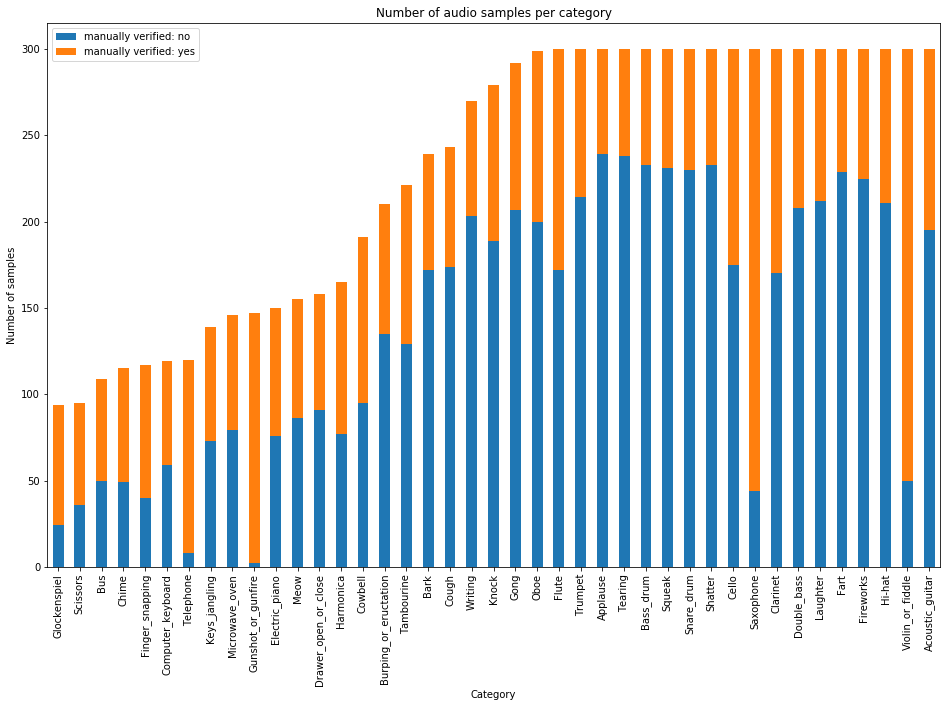

In [67]:
# visualising distribution of categories
ax = manually_verified_unsatck_df.plot(figsize=(16, 10), kind='bar', stacked=True,
        title='Number of audio samples per category')
ax.set_xlabel('Category')
ax.set_ylabel('Number of samples')
ax.legend(['manually verified: no', 'manually verified: yes'])
plt.show()

In [68]:
# please compare it using the plot above
print('Minimum number of audio samples per category: {}'.format(min(train_df['label'].value_counts())))
print('Maximum number of audio samples per category: {}'.format(max(train_df['label'].value_counts())))

Minimum number of audio samples per category: 94
Maximum number of audio samples per category: 300


# Preprocessing audio using torchaudio

In [69]:
# load audio using torch
import torch
import torchaudio

In [70]:
# setting audio file name
AFNAME_TRAIN = TRAIN_DATA_PATH + 'be8a4182.wav'
# AFNAME = '../Data/audio_test/0b0427e2.wav'  # problematic file

# Example: getting waveform, sampling rate and duration of audio

In [71]:
wavedata_raw, sampling_rate_raw = torchaudio.load_wav(AFNAME_TRAIN, normalization=True)  # True is default
duration = wavedata_raw.size()[1] / float(sampling_rate_raw)

In [72]:
# print raw wavedata
print('Shape of wavedata [n_channels, n_frames]: {}'.format(wavedata_raw.size()))
print('Sampling rate of wavedata: {}'.format(sampling_rate_raw))
print('Duration: {} s'.format(duration))
print('Wavedata: {}'.format(wavedata_raw))

Shape of wavedata [n_channels, n_frames]: torch.Size([1, 390726])
Sampling rate of wavedata: 44100
Duration: 8.86 s
Wavedata: tensor([[-1., -1., -2.,  ...,  3., -2., -1.]])


In [73]:
# check whether the raw wavedata tensor is in the interval [-1, 1]
print('Min of wavedata: {}'.format(wavedata_raw.min()))
print('Max of wavedata: {}'.format(wavedata_raw.max()))
print('Mean of wavedata: {}'.format(wavedata_raw.mean()))

Min of wavedata: -26555.0
Max of wavedata: 26258.0
Mean of wavedata: -0.739405632019043


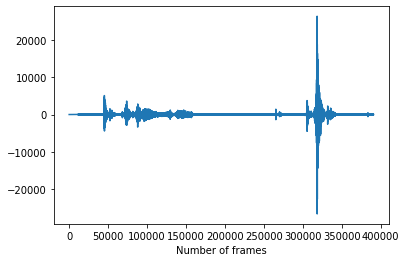

In [74]:
# plot raw wavedata
plt.figure()
plt.plot(wavedata_raw.t().numpy())
plt.xlabel('Number of frames')
plt.show()

# Example of resampling audio

In [75]:
# we may need to resample the data
NEW_SAMPLING_RATE = 16000
RESAMPLE = torchaudio.transforms.Resample(sampling_rate_raw, NEW_SAMPLING_RATE)
wavedata_resampled = RESAMPLE(wavedata_raw[0, :].view(1, -1))
duration = wavedata_resampled.size()[1] / RESAMPLE.new_freq

In [76]:
# print resampled wavedata
print('Resampled data of {}:'.format(AFNAME_TRAIN.split('/')[-1]))
print('Shape of wavedata [n_channels, n_frames]: {}'.format(wavedata_resampled.size()))
print('Sampling rate of wavedata: {}'.format(RESAMPLE.new_freq))
print('Duration: {} s'.format(duration))
print('Wavedata: {}'.format(wavedata_resampled))

Resampled data of be8a4182.wav:
Shape of wavedata [n_channels, n_frames]: torch.Size([1, 141760])
Sampling rate of wavedata: 16000
Duration: 8.86 s
Wavedata: tensor([[-0.8704, -1.1086,  0.3846,  ...,  0.5111, -0.6013,  0.3205]])


In [77]:
# check whether the resampled wavedata tensor is in the interval [-1, 1]
print('Min of wavedata: {}'.format(wavedata_resampled.min()))
print('Max of wavedata: {}'.format(wavedata_resampled.max()))
print('Mean of wavedata: {}'.format(wavedata_resampled.mean()))

Min of wavedata: -23963.07421875
Max of wavedata: 22674.51953125
Mean of wavedata: -0.7397621273994446


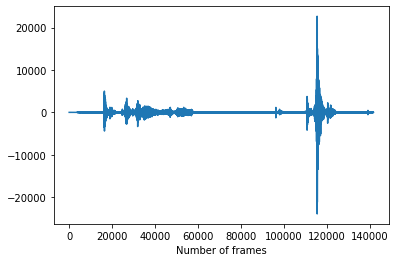

In [78]:
# plot resampled wavedata
plt.figure()
plt.plot(wavedata_resampled.t().numpy())
plt.xlabel('Number of frames')
plt.show()

# Example of normalisation

In [79]:
# probably, we will need to normalise the data
def normalise_waveform(waveform_tensor):
    return waveform_tensor / waveform_tensor.abs().max()
    # Or subtract the mean, and scale to the interval [-1, 1]
    # wf = waveform_tensor - waveform_tensor.mean()
    # return wf / wf.abs().max()

In [80]:
# normalise data
wavedata_norm = normalise_waveform(wavedata_resampled)
duration = wavedata_norm.size()[1] / NEW_SAMPLING_RATE

In [81]:
# print resampled wavedata
print('Normalised data of {}:'.format(AFNAME_TRAIN.split('/')[-1]))
print('Shape of wavedata [n_channels, n_frames]: {}'.format(wavedata_norm.size()))
print('Sampling rate of wavedata: {}'.format(NEW_SAMPLING_RATE))
print('Duration: {} s'.format(duration))
print('Wavedata: {}'.format(wavedata_norm))

Normalised data of be8a4182.wav:
Shape of wavedata [n_channels, n_frames]: torch.Size([1, 141760])
Sampling rate of wavedata: 16000
Duration: 8.86 s
Wavedata: tensor([[-3.6322e-05, -4.6264e-05,  1.6050e-05,  ...,  2.1330e-05,
         -2.5091e-05,  1.3376e-05]])


In [82]:
# check whether the normalised wavedata tensor is in the interval [-1, 1]
print('Min of wavedata: {}'.format(wavedata_norm.min()))
print('Max of wavedata: {}'.format(wavedata_norm.max()))
print('Mean of wavedata: {}'.format(wavedata_norm.mean()))

Min of wavedata: -1.0
Max of wavedata: 0.946227490901947
Mean of wavedata: -3.08709786622785e-05


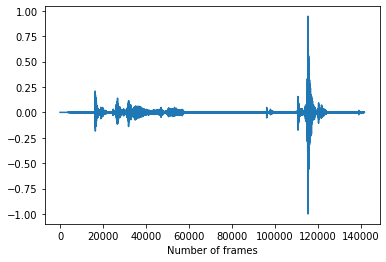

In [83]:
# plot resampled wavedata
plt.figure()
plt.plot(wavedata_norm.t().numpy())
plt.xlabel('Number of frames')
plt.show()

# Getting raw data of all train audio files

In [84]:
# function that returns all (hopefully) necessary raw train data of audio files
def get_raw_audio_data(filename):
    wavedata, sampling_rate = torchaudio.load_wav(TRAIN_DATA_PATH + filename)  # load raw data
    duration = wavedata.size()[1] / sampling_rate
    n_channels, n_frames = wavedata.size()
    return n_channels, n_frames, sampling_rate, duration

In [85]:
# it may take some time to get data of all audio files
train_df['n_channels'], train_df['n_frames'], train_df['sample_rate'], train_df['duration'] =\
        zip(*train_df['fname'].map(get_raw_audio_data))
train_df

,fname,label,manually_verified,freesound_id,license,n_channels,n_frames,sample_rate,duration
0,00044347.wav,Hi-hat,0,28739,Attribution,1,617400,44100,14.00
1,001ca53d.wav,Saxophone,1,358827,Attribution,1,455112,44100,10.32
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0,1,19404,44100,0.44
3,0033e230.wav,Glockenspiel,1,325017,Attribution,1,352800,44100,8.00
4,00353774.wav,Cello,1,195688,Attribution,1,199332,44100,4.52
...,...,...,...,...,...,...,...,...,...
9468,ffec59fb.wav,Fireworks,0,343090,Creative Commons 0,1,516852,44100,11.72
9469,fff37590.wav,Hi-hat,0,33136,Attribution,1,34398,44100,0.78
9470,fff44ac6.wav,Laughter,0,133674,Attribution,1,377496,44100,8.56
9471,fff6a13d.wav,Chime,0,14640,Attribution,1,736470,44100,16.70


# Checking whether audio files have different number of channels / sampling rate

In [86]:
# check whether there are different number of channels
n_channels_train = train_df['n_channels'].unique()
print('Channels: {}'.format(n_channels_train))

Channels: [1]


In [87]:
# get min and max number of frames
print('Min number of frames: {}'.format(train_df['n_frames'].min()))
print('Max number of frames: {}'.format(train_df['n_frames'].max()))

Min number of frames: 13230
Max number of frames: 1323000


In [88]:
# check whether there are different sampling rates
sample_rates_train = train_df['sample_rate'].unique()
print('Sample rates: {}'.format(sample_rates_train))

Sample rates: [44100]


In [89]:
# get min and max duration
print('Min duration: {} s'.format(train_df['duration'].min()))
print('Max duration: {} s'.format(train_df['duration'].max()))

Min duration: 0.3 s
Max duration: 30.0 s


# Getting raw data of all test audio files

In [90]:
# get data of all test audio files
def get_raw_audio_data_test(filename):
    wavedata, sampling_rate = torchaudio.load_wav(TEST_DATA_PATH + filename)  # load raw data
    duration = wavedata.size()[1] / sampling_rate
    n_channels, n_frames = wavedata.size()
    return n_channels, n_frames, sampling_rate, duration

In [91]:
test_df['n_channels'], test_df['n_frames'], test_df['sample_rate'], test_df['duration'] =\
        zip(*test_df['fname'].map(get_raw_audio_data_test))
test_df

,fname,label,usage,freesound_id,license,n_channels,n_frames,sample_rate,duration
0,00326aa9.wav,Oboe,Private,355125,Attribution,1,91728,44100,2.08
1,0038a046.wav,Bass_drum,Private,90621,Creative Commons 0,1,171990,44100,3.90
2,007759c4.wav,Saxophone,Private,13406,Creative Commons 0,1,442764,44100,10.04
3,008afd93.wav,Saxophone,Private,358962,Attribution,1,416304,44100,9.44
4,00ae03f6.wav,Chime,Private,78203,Attribution,1,392490,44100,8.90
...,...,...,...,...,...,...,...,...,...
1595,ff96680f.wav,Meow,Private,352227,Attribution,1,86436,44100,1.96
1596,ffa69cfc.wav,Telephone,Private,66290,Attribution,1,154350,44100,3.50
1597,ffaca82d.wav,Scissors,Public,332471,Creative Commons 0,1,1178352,44100,26.72
1598,ffb6eb52.wav,Cowbell,Private,91139,Creative Commons 0,1,126126,44100,2.86


# Checking whether audio files have different number of channels / sampling rate

In [92]:
# check whether there are different number of channels
n_channels_test = test_df['n_channels'].unique()
print('Channels: {}'.format(n_channels_test))

Channels: [1]


In [93]:
# get min and max number of frames
print('Min number of frames: {}'.format(test_df['n_frames'].min()))
print('Max number of frames: {}'.format(test_df['n_frames'].max()))

Min number of frames: 13230
Max number of frames: 1311534


In [94]:
# check whether there are different sampling rates
sample_rates_test = test_df['sample_rate'].unique()
print('Sample rates: {}'.format(sample_rates_test))

Sample rates: [44100]


In [95]:
# get min and max duration
print('Min duration: {} s'.format(test_df['duration'].min()))
print('Max duration: {} s'.format(test_df['duration'].max()))

Min duration: 0.3 s
Max duration: 29.74 s


#  Frame length distribution

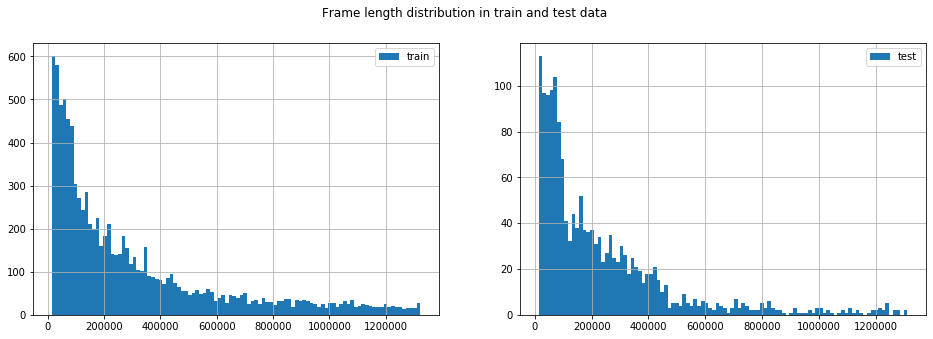

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
train_df['n_frames'].hist(bins=100, ax=axes[0], label='train')
test_df['n_frames'].hist(bins=100, ax=axes[1], label='test')
[ax.legend() for ax in axes]
plt.suptitle('Frame length distribution in train and test data', ha='center', fontsize='large')
plt.show()

--EOF--